In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.ticker as ticker

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

from scipy.interpolate import griddata


In [8]:
# --- Load vmem simulation data ---
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [10]:
def extract_simulation_points(vmem_amp_data, target_freq):
    l1_list = []
    l2_list = []
    Vm_list = []

    for cell_id, data in vmem_amp_data.items():
        freqs = np.array(data['freq'])
        soma_amp = np.array(data['soma_amp'])

        # Find closest frequency
        idx = np.argmin(np.abs(freqs - target_freq))

        l1 = data['upper_z_endpoint']          # already in µm?
        l2 = abs(data['bottom_z_endpoint'])

        l1_list.append(l1)
        l2_list.append(l2)
        Vm_list.append(soma_amp[idx])

    return np.array(l1_list), np.array(l2_list), np.array(Vm_list)


In [21]:
def simulation_heatmap(vmem_amp_data, l1_values, l2_values, f0):
    """
    Create a heatmap using only existing simulation points.
    If multiple cells share the same (l1, l2), average Vm.
    """

    # Grid in µm (to match simulation units)
    l1_grid_um = l1_values * 1e6
    l2_grid_um = l2_values * 1e6

    # Storage: list of values per grid cell
    Vm_bins = [[[] for _ in range(len(l2_grid_um))]
               for _ in range(len(l1_grid_um))]

    for cell_id, data in vmem_amp_data.items():
        freqs = np.asarray(data['freq'])
        soma_amp = np.asarray(data['soma_amp'])

        # Closest frequency
        idx_f = np.argmin(np.abs(freqs - f0))
        Vm = soma_amp[idx_f]

        # Extract geometry (µm)
        l1 = data['upper_z_endpoint']
        l2 = abs(data['bottom_z_endpoint'])

        # Find nearest grid index
        i = np.argmin(np.abs(l1_grid_um - l1))
        j = np.argmin(np.abs(l2_grid_um - l2))

        Vm_bins[i][j].append(Vm)

    # Convert lists → averaged grid
    Vm_grid = np.full((len(l1_grid_um), len(l2_grid_um)), np.nan)

    for i in range(len(l1_grid_um)):
        for j in range(len(l2_grid_um)):
            if Vm_bins[i][j]:
                Vm_grid[i, j] = np.mean(Vm_bins[i][j])

    return Vm_grid


In [22]:
def param_sweep_analytic_Vm_2d(params, param_name_1, param_values_1, param_name_2, param_values_2, f0=1000.0):
    """
    Sweeps one parameter and calculates Transfer function at fixed frequency.

    Args:
        params (dict): Biophysical parameters (same as before).
        param_name (str): Name of the parameter to vary (e.g. 'l1', 'l2', 'ds').
        param_values (np.ndarray): Array of values to sweep over.
        f0 (float): Frequency (Hz) at which to evaluate the transfer function.

    Returns:
        dict: A dictionary containing:
            - param_values (np.ndarray): The swept parameter values.
            - V_m (np.ndarray): Analytical Vm at f0 for each param value.
    """
    # Angular frequency
    omega = 2 * np.pi * f0
    if omega == 0:
        omega += 1e-9

    shape = (len(param_values_1), len(param_values_2))
    results = {
        "param_values_1": param_values_1,
        "param_values_2": param_values_2,
        "V_m": np.zeros(shape, dtype=np.float64)
    }

    for i, val1 in enumerate(param_values_1):
        for j, val2 in enumerate(param_values_2):
            # Copy params and replace the swept parameter
            p = params.copy()
            p[param_name_1] = val1
            p[param_name_2] = val2

            # --- Extract parameters ---
            Rm, Ri, Cm = p['Rm'], p['Ri'], p['Cm']
            d, ds, l1, l2, s_in = p['d'], p['ds'], p['l1'], p['l2'], p['s_in']

            # --- Derived properties ---
            tau_m = Rm * Cm
            lambda_ = np.sqrt((d * Rm) / (4 * Ri))
            L1, L2 = l1 / lambda_, l2 / lambda_
            W = omega * tau_m
            q = np.sqrt(1 + 1j * W)

            # Soma admittance
            Ys = np.pi * ds**2 * (1/Rm) * q**2

            # Infinite-stick admittance
            G_inf = np.pi * d**2 / (4 * Ri * lambda_)
            Y_inf = q * G_inf

            # Total admittance
            Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

            # Transfer function numerator/denominator
            numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))
            denominator = Y_in_total

            T_p = numerator / denominator

            V_m = 1e3*np.abs(T_p)

            # Store
            results["V_m"][i,j] = V_m

    return results


In [26]:
def plot_len_heatmaps(params, l1_values, l2_values, freqs):

    fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharey=False)

    # ==========================================================
    # ANALYTIC — 10 Hz (A)
    # ==========================================================
    f0_1 = freqs[0]
    results_1 = param_sweep_analytic_Vm_2d(
        params,
        param_name_1='l1',
        param_values_1=l1_values,
        param_name_2='l2',
        param_values_2=l2_values,
        f0=f0_1
    )

    im1 = axes[0, 0].imshow(
        results_1["V_m"].T,
        extent=[l1_values[0]*1e6, l1_values[-1]*1e6,
                l2_values[0]*1e6, l2_values[-1]*1e6],
        origin="lower",
        aspect="auto",
        cmap="viridis"
    )

    cbar1 = fig.colorbar(im1, ax=axes[0, 0])
    cbar1.ax.set_ylabel(r"$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]")
    fmt1 = ticker.ScalarFormatter(useMathText=True)
    fmt1.set_powerlimits((-2, 2))
    fmt1.set_useOffset(False)
    cbar1.ax.yaxis.set_major_formatter(fmt1)

    axes[0, 0].set_title(f"{f0_1} Hz")
    axes[0, 0].set_xlabel(r"Dendrite length $l_1$ [µm]")
    axes[0, 0].set_ylabel(r"Dendrite length $l_2$ [µm]")

    axes[0, 0].scatter(787, 255, color="red", s=8)
    axes[0, 0].scatter(220, 280, color="red", s=8)
    axes[0, 0].text(737, 175, "Pyramidal\naverage", color="red", fontsize=8)
    axes[0, 0].text(170, 330, "Inhibitory\naverage", color="red", fontsize=8)

    axes[0, 0].text(-0.3, 1.10, 'A',
                     transform=axes[0, 0].transAxes,
                     fontsize=12, fontweight='bold')

    # ==========================================================
    # ANALYTIC — 1000 Hz (B)
    # ==========================================================
    f0_2 = freqs[1]
    results_2 = param_sweep_analytic_Vm_2d(
        params,
        param_name_1='l1',
        param_values_1=l1_values,
        param_name_2='l2',
        param_values_2=l2_values,
        f0=f0_2
    )

    im2 = axes[0, 1].imshow(
        results_2["V_m"].T,
        extent=[l1_values[0]*1e6, l1_values[-1]*1e6,
                l2_values[0]*1e6, l2_values[-1]*1e6],
        origin="lower",
        aspect="auto",
        cmap="viridis"
    )

    cbar2 = fig.colorbar(im2, ax=axes[0, 1])
    cbar2.ax.set_ylabel(r"$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]")
    fmt2 = ticker.ScalarFormatter(useMathText=True)
    fmt2.set_powerlimits((-2, 2))
    fmt2.set_useOffset(False)
    cbar2.ax.yaxis.set_major_formatter(fmt2)

    axes[0, 1].set_title(f"{f0_2} Hz")
    axes[0, 1].set_xlabel(r"Dendrite length $l_1$ [µm]")
    axes[0, 1].set_ylabel(r"Dendrite length $l_2$ [µm]")

    axes[0, 1].scatter(787, 255, color="red", s=8)
    axes[0, 1].scatter(220, 280, color="red", s=8)

    axes[0, 1].text(-0.3, 1.10, 'B',
                     transform=axes[0, 1].transAxes,
                     fontsize=12, fontweight='bold')

    # ==========================================================
    # SIMULATION — 10 Hz (C)
    # ==========================================================
    Vm_sim_10 = simulation_heatmap(
        vmem_amp_data, l1_values, l2_values, f0=10
    )

    im3 = axes[1, 0].imshow(
        Vm_sim_10.T,
        extent=[l1_values[0]*1e6, l1_values[-1]*1e6,
                l2_values[0]*1e6, l2_values[-1]*1e6],
        origin="lower",
        aspect="auto",
        cmap="viridis"
    )

    cbar3 = fig.colorbar(im3, ax=axes[1, 0])
    cbar3.ax.set_ylabel(r"Soma $V_m$ amplitude, Simulation [mV]")

    axes[1, 0].set_title("Simulation 10 Hz")
    axes[1, 0].set_xlabel(r"Dendrite length $l_1$ [µm]")
    axes[1, 0].set_ylabel(r"Dendrite length $l_2$ [µm]")

    axes[1, 0].text(-0.3, 1.10, 'C',
                     transform=axes[1, 0].transAxes,
                     fontsize=12, fontweight='bold')

    # ==========================================================
    # SIMULATION — 1000 Hz (D)
    # ==========================================================
    Vm_sim_1000 = simulation_heatmap(
        vmem_amp_data, l1_values, l2_values, f0=1000
    )

    im4 = axes[1, 1].imshow(
        Vm_sim_1000.T,
        extent=[l1_values[0]*1e6, l1_values[-1]*1e6,
                l2_values[0]*1e6, l2_values[-1]*1e6],
        origin="lower",
        aspect="auto",
        cmap="viridis"
    )

    cbar4 = fig.colorbar(im4, ax=axes[1, 1])
    cbar4.ax.set_ylabel(r"Soma $V_m$ amplitude, Simulation [mV]")

    axes[1, 1].set_title("Simulation 1000 Hz")
    axes[1, 1].set_xlabel(r"Dendrite length $l_1$ [µm]")
    axes[1, 1].set_ylabel(r"Dendrite length $l_2$ [µm]")

    axes[1, 1].text(-0.3, 1.10, 'D',
                     transform=axes[1, 1].transAxes,
                     fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(
        '/Users/susannedahle/Documents/Master/Code/fig_pdfs/transfer/fig9.pdf'
    )
    plt.show()


In [27]:
standard_neuron_parameters = {
    'Rm': 3.0,          # Ohm * m^2
    'Ri': 1.5,          # Ohm * m
    'Cm': 0.01,         # F / m^2
    'd': 2e-6,          # 2 µm -> m
    'ds': 20e-6,        # 20 µm -> m
    'l1': 670e-6,       # 670 µm -> m (Longer stick)
    'l2': 330e-6,       # 330 µm -> m (Shorter stick)
    's_in': (1e-15)**2  # 1 fA^2/Hz -> A^2/Hz
}

neuron_parameters = standard_neuron_parameters.copy()
l1_values = np.linspace(50e-6, 1000e-6, 100)
l2_values = np.linspace(50e-6, 1000e-6, 100)
frequencies_to_plot = [10, 1000]

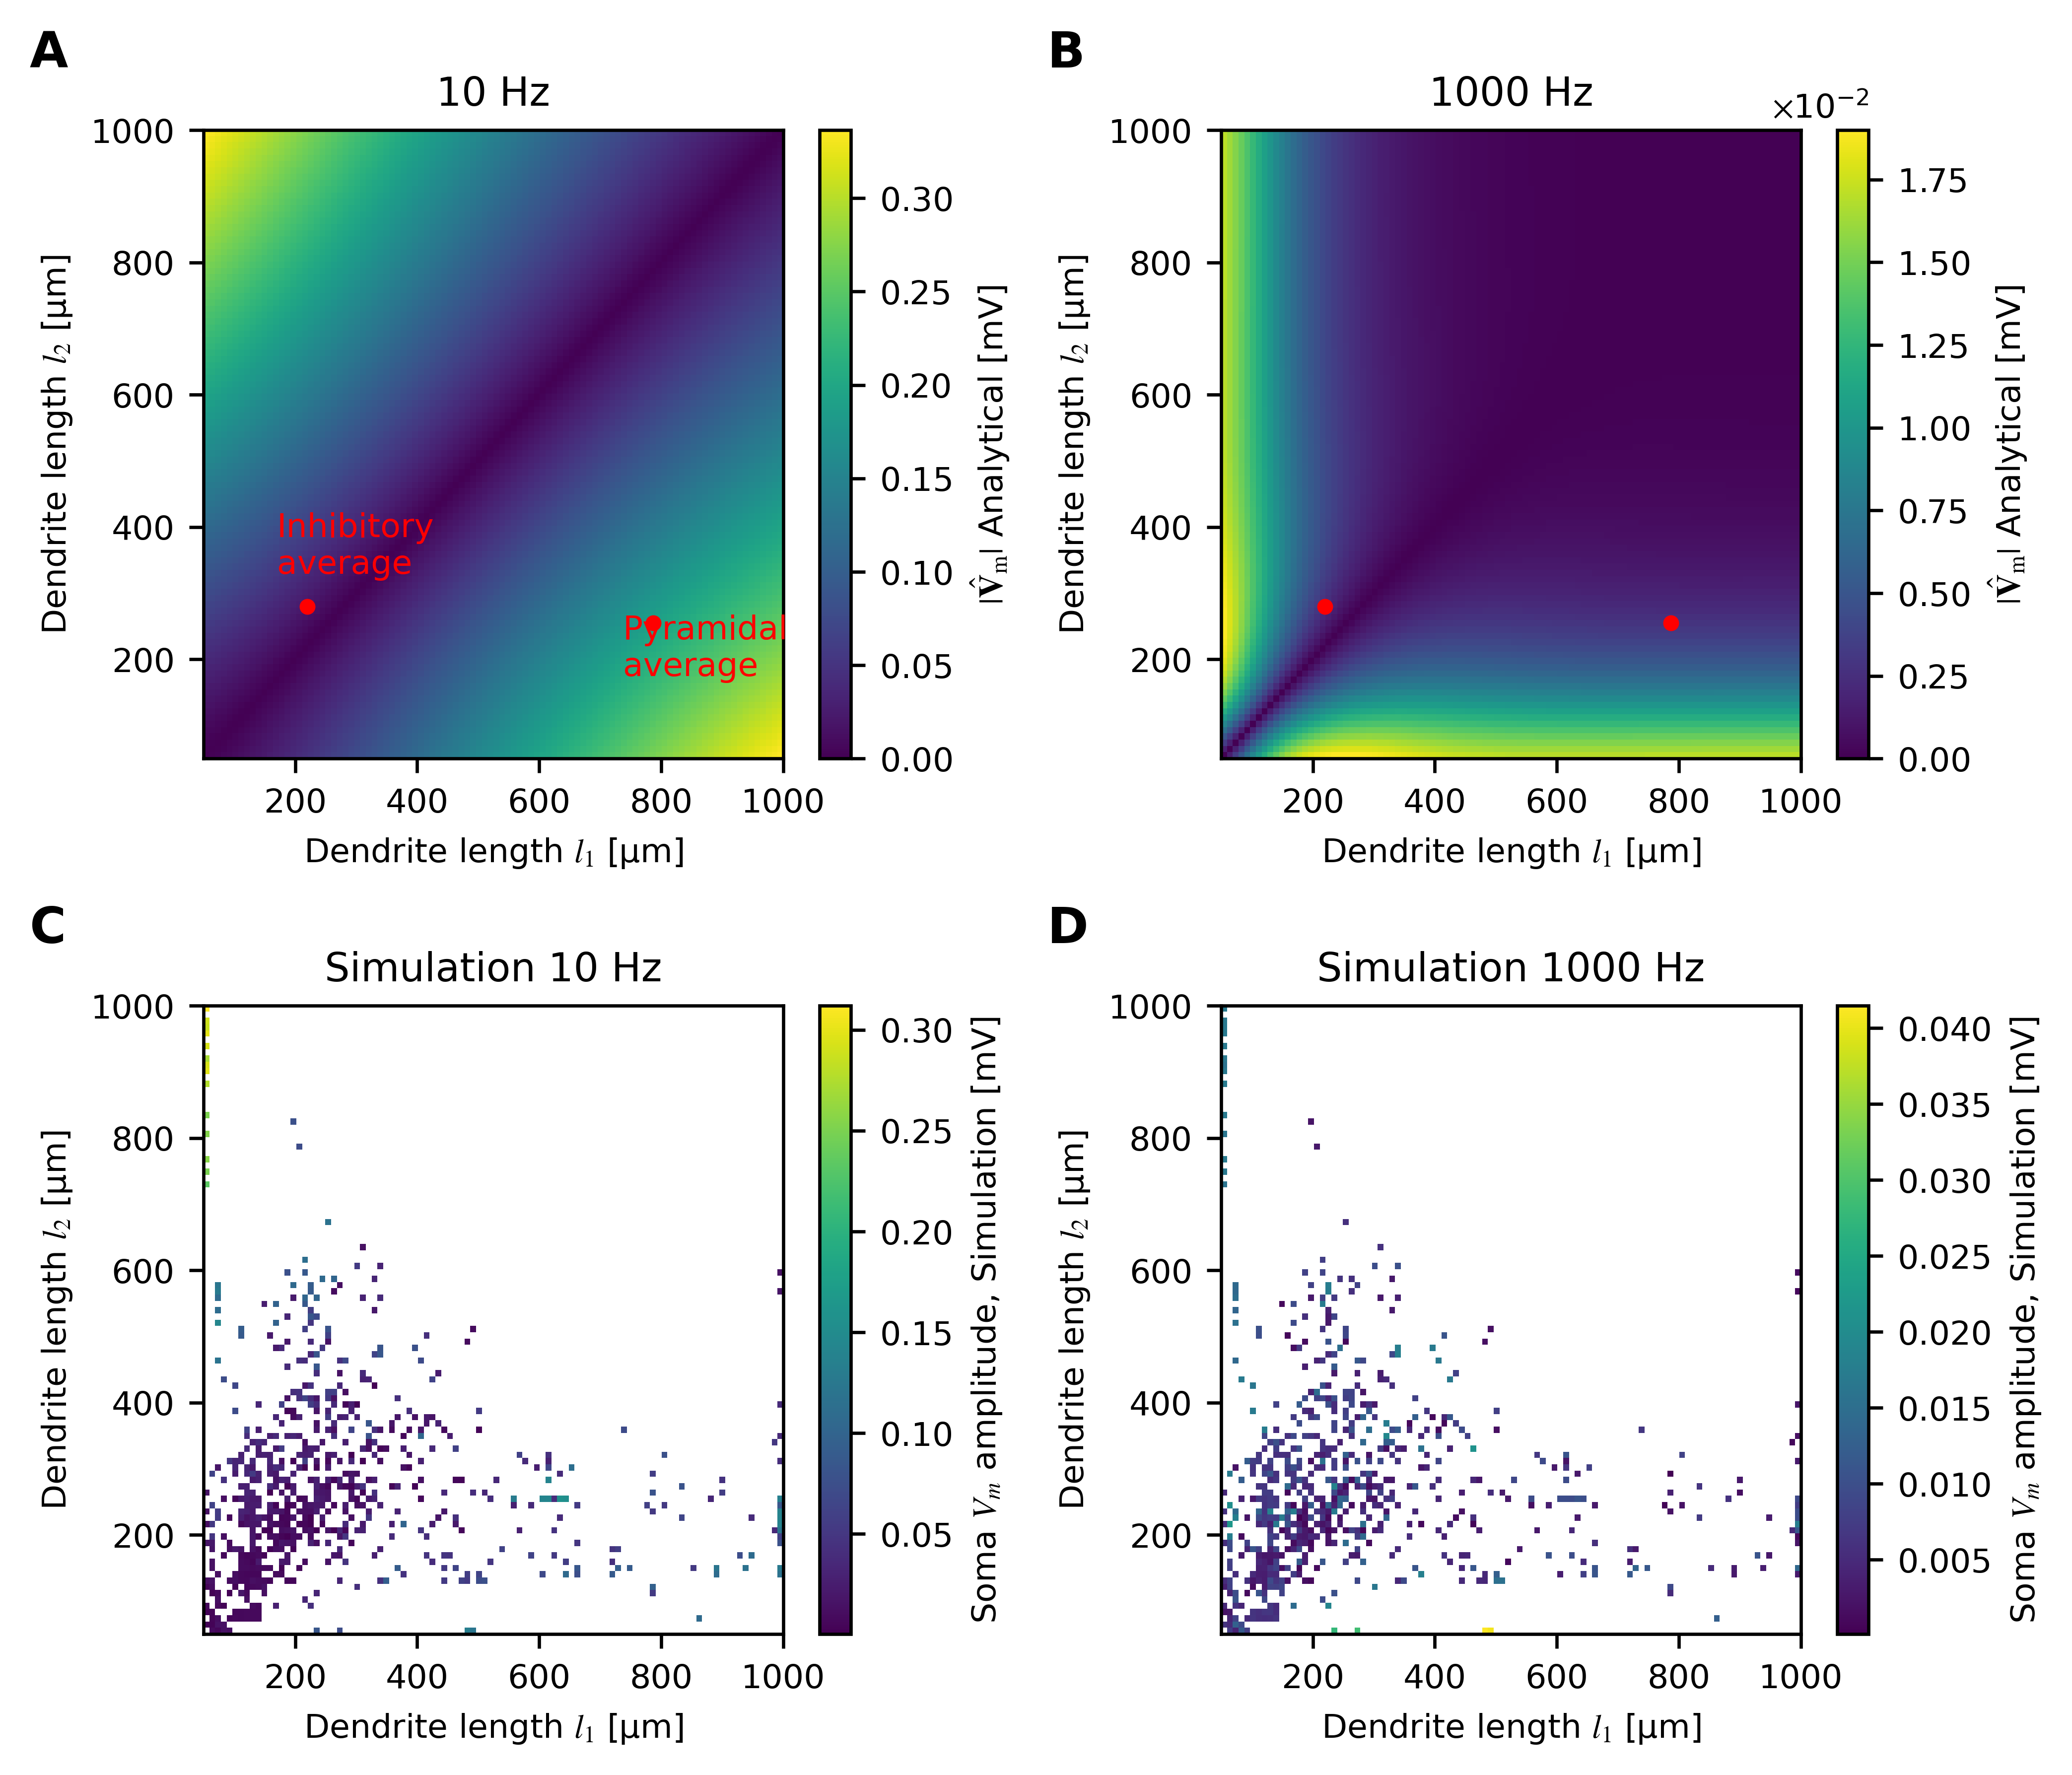

In [28]:
plot_len_heatmaps(
    params=neuron_parameters, 
    l1_values=l1_values,
    l2_values=l2_values,
    freqs=frequencies_to_plot
)